In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data loading and Pre- Processing

In [3]:
# Housekeeping
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
#defining the dataset path and directories
base_path = 'dataset/chest_xray'
dir_train = os.path.join(base_path, 'train')
dir_val = os.path.join(base_path, 'val')
dir_test = os.path.join(base_path, 'test')


In [5]:
# Now, defining our image data generator with preprocessing

#augumentation
train_dataGen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2, horizontal_flip= True)


# No Augumentation for test
test_dataGen = ImageDataGenerator(rescale=1./255)

#loading imgages from the directories
train_Gen = train_dataGen.flow_from_directory(dir_train, target_size=(150,150), batch_size=20, class_mode='binary')

valid_Gen = test_dataGen.flow_from_directory(dir_val, target_size=(150,150), batch_size=20, class_mode='binary')

test_Gen = test_dataGen.flow_from_directory(dir_test, target_size=(150,150), batch_size=20, class_mode='binary')



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
%pip install Pillow
from PIL import Image
import os

# checking if there is any bad images in all the directories that need to be taken out.
def check_badimages(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check for an appropriate image file extension before proceeding
            if file.lower().endswith(('jpg', 'jpeg', 'png')):  # Ensuring case-insensitive comparison
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)  # Opening the image file
                    img.verify()  #check if its an image
                except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                    print('Bad file:', path)  # Printing the names of corrupt files


# usage
check_badimages(dir_train)
check_badimages(dir_test)
check_badimages(dir_val)


Note: you may need to restart the kernel to use updated packages.
Bad file: dataset/chest_xray\train\NORMAL\NORMAL2-IM-1178-0001.jpeg


# DenseNet

## Model Building

This employs DenseNet121 as the feature extractor, incorporates custom dense layers, and designates the pre-trained model layers as non-trainable to retain the acquired features.

In [7]:
from tensorflow.keras.applications import DenseNet121 as DN
from tensorflow.keras import layers, models

#now we will be loading the pre=trained DenseNet
base_dense_mod = DN(include_top=False, weights='imagenet', input_shape=(150, 150,3))

#customized layers
x = base_dense_mod.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256,activation='relu')(x)
predict = layers.Dense(1, activation= 'sigmoid')(x)

model = models.Model(inputs= base_dense_mod.input, outputs= predict)

# freezing the base model layers
for layer in base_dense_mod.layers:
    layer.trainable = False

## Model Compilation

Here, the accuracy metric, binary cross-entropy loss function (fit for binary classification tasks), and Adam optimizer are used to create the model.




In [8]:
"""Defining the optimizer, loss function, and metrics"""

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics= ['accuracy'])


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

# Load pre-trained DenseNet
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
#training
history = model.fit(train_generator, steps_per_epoch=100, epochs=10, validation_data=validation_generator, validation_steps=50)

import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Hyperparameter Tuning
pip install keras-tuner

from kerastuner import HyperModel
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

class DenseNetHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=self.input_shape)
        base_model.trainable = False  # Freeze the base model

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(
            units=hp.Int('units', min_value=128, max_value=512, step=32),
            activation='relu'
        )(x)
        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=base_model.input, outputs=output)

        model.compile(
            optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

#perform hyperparameter search

from kerastuner.tuners import RandomSearch

hypermodel = DenseNetHyperModel(input_shape=(150, 150, 3))

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_densenet'
)

tuner.search(train_generator, validation_data=validation_generator, epochs=10)

#crossfold

from sklearn.model_selection import KFold
import numpy as np

# Assuming you have loaded your dataset into X (images) and y (labels)
# For demonstration, let's consider X and y are ready
X = np.array(train_generator)  # Placeholder
y = np.array(validation_generator)  # Placeholder

kf = KFold(n_splits=5)  # Define number of splits

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create a new model (or clear the existing model)
    model = create_model()  # `create_model` should build a new Keras model

    # Fit the model
    model.fit(X_train, y_train, epochs=10)

    # Evaluate the model
    score = model.evaluate(X_test, y_test)
    print(score)


## Training

By iterating over batches of images, the model is trained for 25 epochs, and its performance is verified on the validation set.



In [16]:
# Training the model using the training and validation data

hist = model.fit(train_Gen, steps_per_epoch=10, epochs=25,validation_data=valid_Gen, validation_steps=50)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 542ms/step - accuracy: 0.9551 - loss: 0.1329 - val_accuracy: 0.6875 - val_loss: 0.4132
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - accuracy: 0.9063 - loss: 0.2109 - val_accuracy: 0.7500 - val_loss: 0.3788
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - accuracy: 0.8569 - loss: 0.2774 - val_accuracy: 0.7500 - val_loss: 0.3653
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - accuracy: 0.9126 - loss: 0.1942 - val_accuracy: 0.8125 - val_loss: 0.1435
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 460ms/step - accuracy: 0.8349 - loss: 0.3953 - val_accuracy: 0.8750 - val_loss: 0.1617
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - accuracy: 0.9468 - loss: 0.2114 - val_accuracy: 0.7500 - val_loss: 0.3611
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - accuracy: 0.9278 - loss: 0.1910 - val_accuracy: 0.8125 - val_loss: 0.1462
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 483ms/step - accuracy: 0.8830 - loss: 0.2737 - val_accuracy: 0.

## Evaluation and Analysis

Analyse the model's performance using the test set and present the results visually.

The training and validation accuracy per epoch can be seen in the plots below, which aid in the analysis of the model's learning and the identification of any overfitting or underfitting.

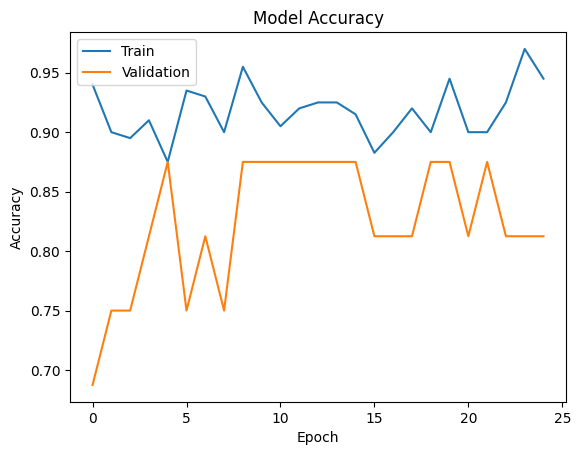

In [19]:
import matplotlib.pyplot as plt

#plots of training and Validation accuracy

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Hyperparameter Tuning

The given code presents a DenseNetHyperModel class that allows for the specification of hyperparameters such as the number of units in the dense layers and the type of optimizer.

In [21]:
%pip install keras-tuner

In [23]:
from kerastuner import HyperModel
from tensorflow.keras.applications import DenseNet121 as DN121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

class DenseNetHyper_Model(HyperModel):
    def __init__(self, shape_input):
        self.shape_input = shape_input

    def Build(self,HP):
        Base_Model = DN121(include_top= False, weights='imagenet', input_shape= self.shape_input)
        Base_Model.trainable = False #freezing the base model

        x = Base_Model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=HP.Int('units', min_value=128, max_value=512, steps=32), activation='relu')(x)
        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs = Base_Model.input, outputs = output)

        model.compile(optimizer=HP.Choice('optimizer', ['Adam', 'sgd']),loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    

                  